Примечание: это вторая часть задания.

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

478

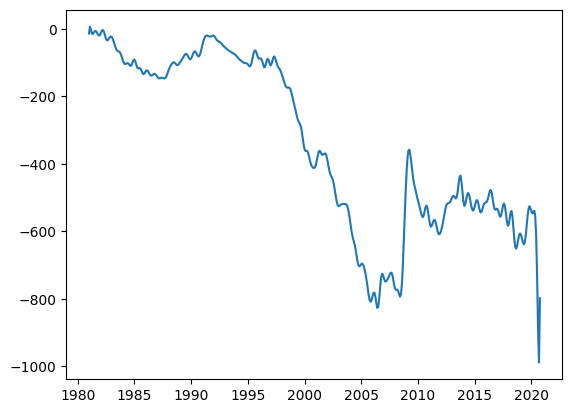

In [27]:
qrr = pd.read_csv('macro_quarterly.csv')
qrr_index = pd.to_datetime(qrr["date"], format="%d/%m/%Y")
qrr = qrr.drop(["date"], axis="columns")
qrr.index = qrr_index
qrr = qrr.asfreq("MS").interpolate(method='polynomial', order=7)
plt.plot(qrr["netexp"])
len(qrr["gdp"])

In [28]:
mth = pd.read_csv('macro_monthly.csv')
df_index = pd.to_datetime(mth["DATE"], format="%Y-%m-%d")
mth = mth.drop(["DATE"], axis="columns")
mth.index = df_index
df = mth.copy(deep=True)
for c in qrr.columns:
    df[c] = qrr[c].copy(deep=True)
#df["reer"] = df["reer"].fillna(df["reer"].mean())
#df["tcs"] = df["tcs"].fillna(df["tcs"].mean())
df = df.dropna().asfreq('W').interpolate(method='polynomial', order=1).dropna()

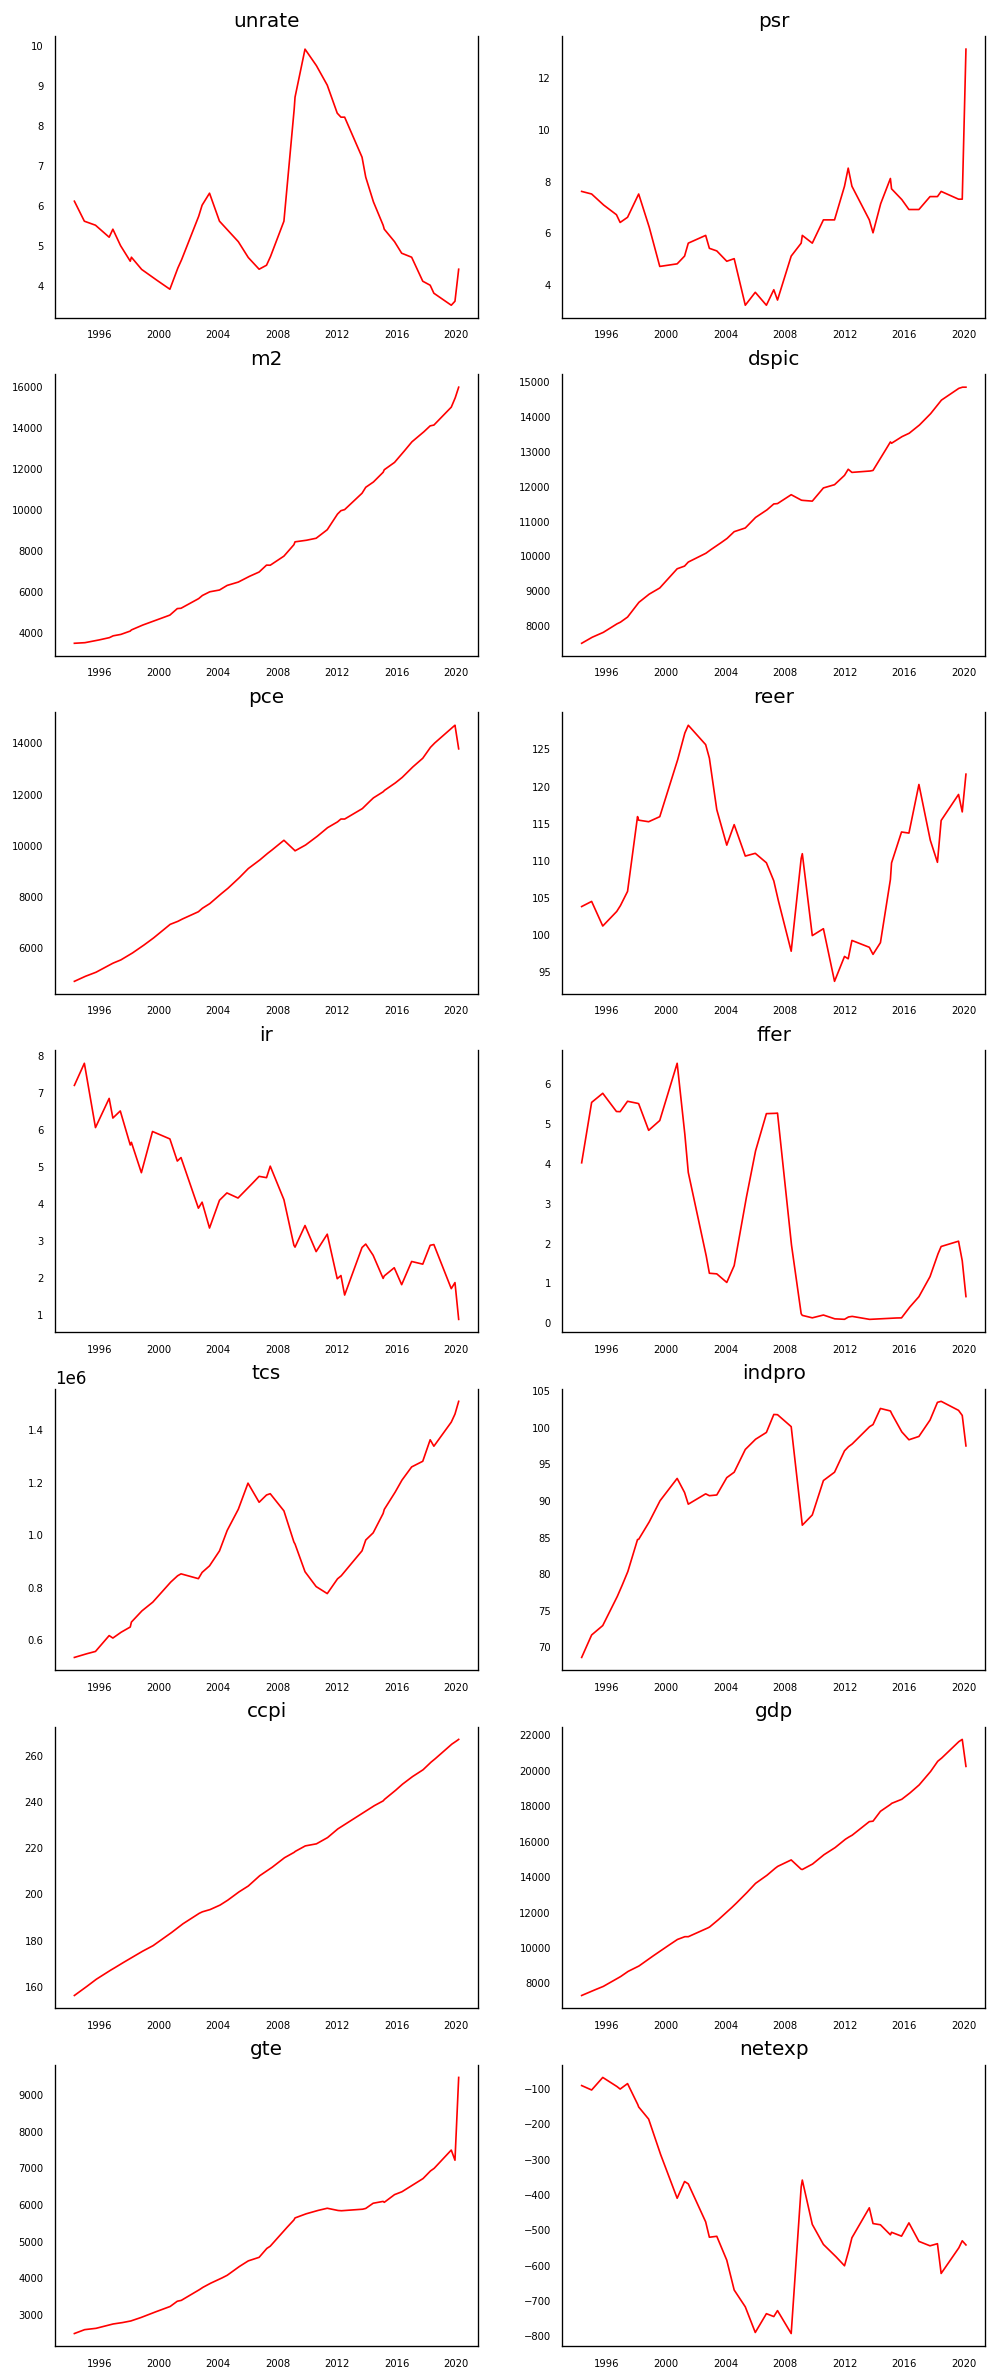

In [29]:
fig, axes = plt.subplots(nrows=7, ncols=2, dpi=120, figsize=(10,25))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.show()

In [30]:
train = df[:int(0.9*(len(data)))]
test = df[int(0.9*(len(data))):]

In [31]:
import numpy as np
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                            r2_score)
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(true, pred):
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred))

### Нейронные сети

##### RNN

In [9]:
!pip install scikeras

In [10]:
import torch
from torch import nn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [11]:
def createXY(dataset,n_past):
    #dataset = ds.values
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,:])
    return np.array(dataX),np.array(dataY)

In [12]:
import numpy as np
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                            r2_score)
from math import sqrt

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def validate(true, pred):
    print("MSE:", mean_squared_error(true, pred))
    print("RMSE:", sqrt(mean_squared_error(true, pred)))
    print("MAE:", mean_absolute_error(true, pred))
    print("MAPE:", mean_absolute_percentage_error(true, pred))
    print("R2:", r2_score(true, pred))

In [ ]:
from sklearn.metrics import mean_absolute_error
import copy
def build_model(npas, hout, p):
    icol = 14
    grid_model = Sequential()
    grid_model.add(SimpleRNN(hout, input_shape=(npas,icol), activation='relu'))
    grid_model.add(Dropout(p))
    grid_model.add(Dense(icol))

    grid_model.compile(loss = 'mse', optimizer = Adam(learning_rate=1e-3))
    return grid_model


min_error = None
best_params = {'npas': 1, 'hout': 2, 'p': 3}
for p in [0.05]:
    for hout in [1000, 2500]:
        for n_past in range(1, 11):
            params = {'npas': n_past*12, 'hout': hout, 'p': p}
            print("; ".join([key + ': ' + str(params[key]) for key in params.keys()]))
            npas = n_past * 12
            trainX,trainY=createXY(train,npas)
            testX,testY=createXY(pd.concat([train.iloc[-npas:,:], test]),npas)
            #grid_model = KerasRegressor(model=build_model(npas, hout, p),verbose=1, fit__validation_data=(testX,testY))
            grid_model = build_model(npas, hout, p)
            '''grid_search  = GridSearchCV(estimator = grid_model,
                                param_grid = {'epochs': [15]},
                                cv = 2,
                                verbose=True)'''

            blindshot=grid_model.predict(testX)
            print("MAE without education:" + str(mean_absolute_error(blindshot, testY)))
            grid_fit = grid_model.fit(trainX,trainY,epochs=128,batch_size=512,verbose=0)
            prediction=grid_model.predict(testX)
            print("MAE with education:" + str(mean_absolute_error(prediction, testY)))
            print()
            if min_error is None or mean_absolute_error(prediction, testY) < min_error:
                best_params = {'npas': npas, 'hout': hout, 'p': p}
                min_error = mean_absolute_error(prediction, testY)
                best = copy.deepcopy(prediction)
                best_test = copy.deepcopy(testY)

npas: 12; hout: 1000; p: 0.05
2/2 [==============================] - 0s 13ms/step
MAE without education:159914.8915149821
2/2 [==============================] - 0s 10ms/step
MAE with education:2895.9995841754317

npas: 24; hout: 1000; p: 0.05
2/2 [==============================] - 0s 12ms/step
MAE without education:162120.03409374738
2/2 [==============================] - 0s 12ms/step
MAE with education:3565.4662901269553

npas: 36; hout: 1000; p: 0.05
2/2 [==============================] - 0s 15ms/step
MAE without education:178826.32706993917
2/2 [==============================] - 0s 16ms/step
MAE with education:3387.0452441573107

npas: 48; hout: 1000; p: 0.05
2/2 [==============================] - 0s 20ms/step
MAE without education:146582.1267375259
2/2 [==============================] - 0s 19ms/step
MAE with education:3466.251006144444

npas: 60; hout: 1000; p: 0.05
2/2 [==============================] - 0s 24ms/step
MAE without education:154778.74625274073
2/2 [===================

In [ ]:
#grid_search = grid_search.fit(trainX,trainY)
for key in best_params.keys():
    print(key, ': ', best_params[key], sep="")

npas: 12
hout: 1000
p: 0.05


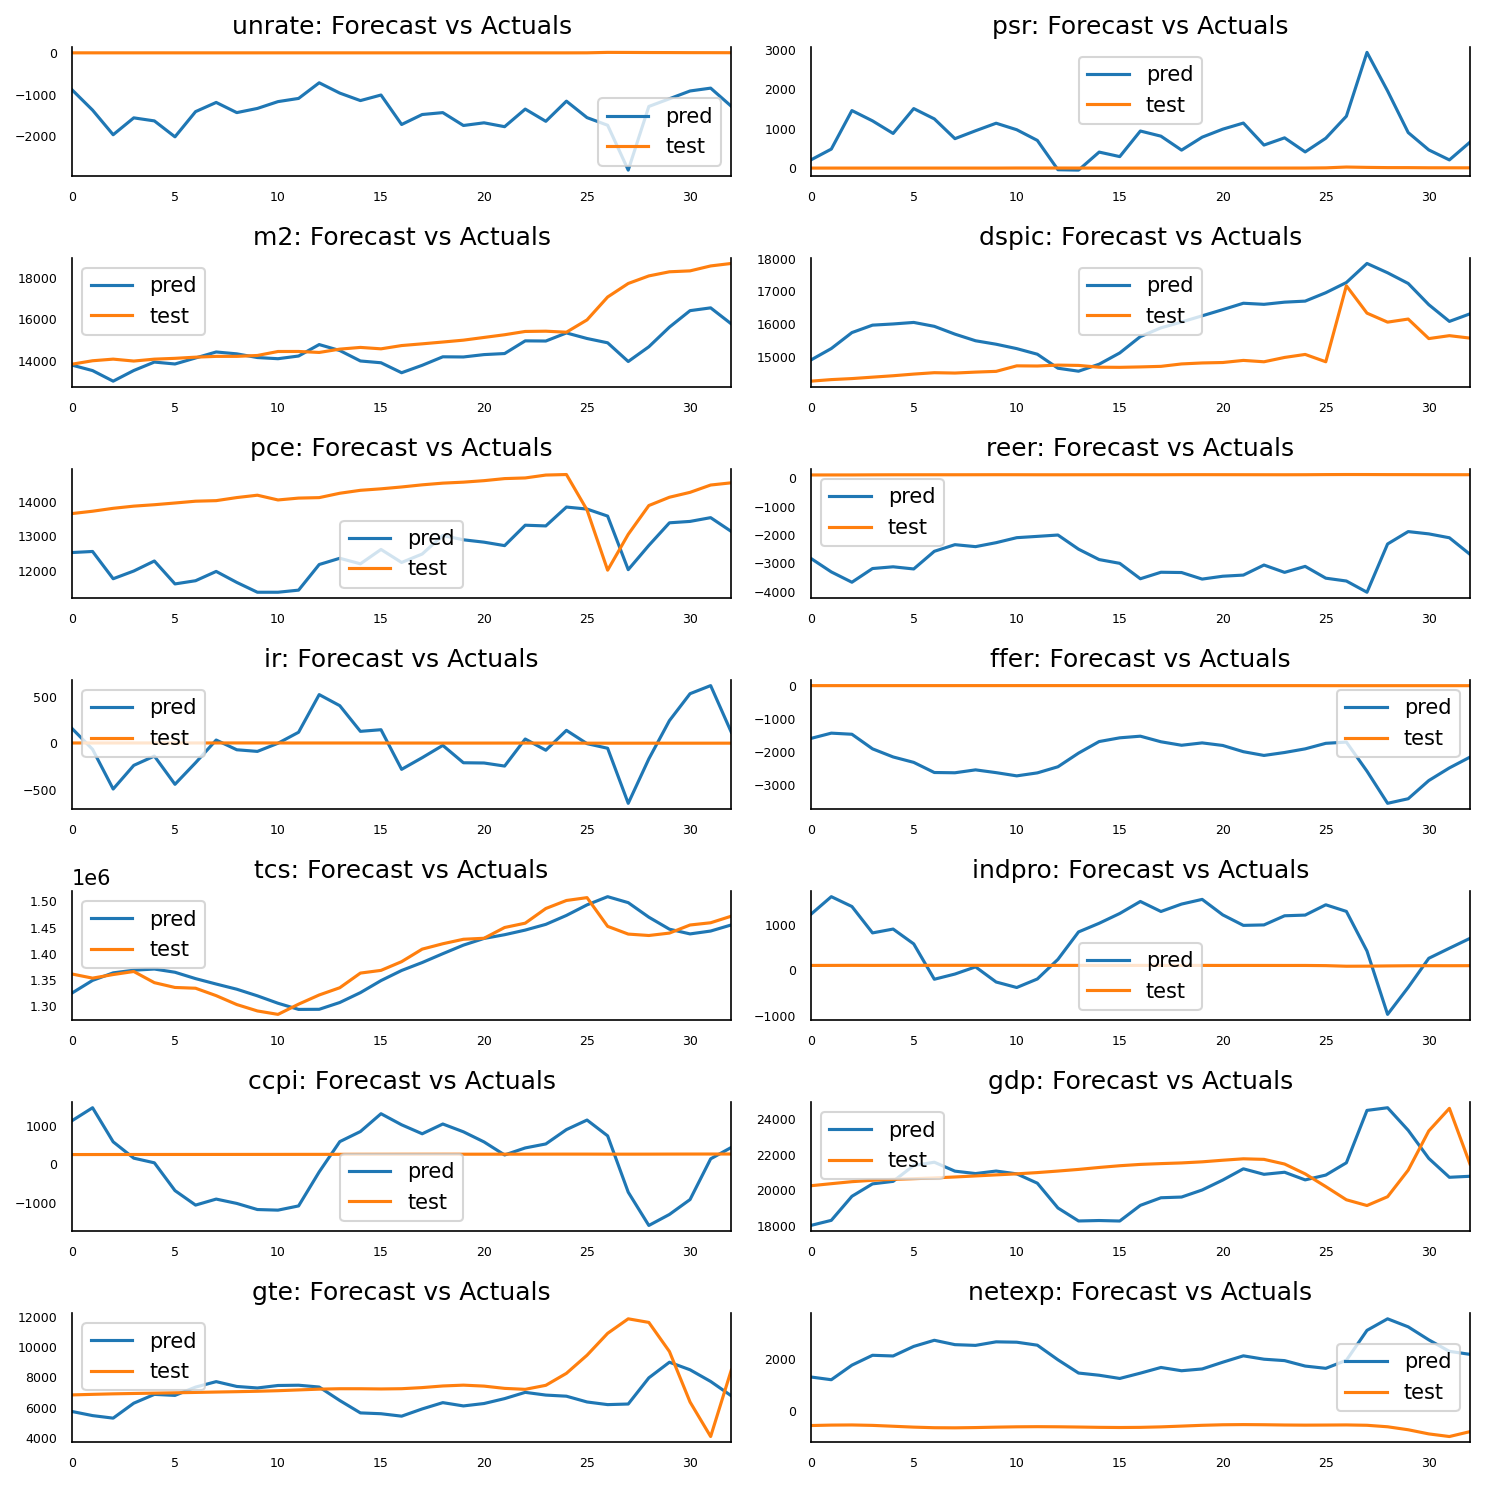

In [ ]:
fig, axes = plt.subplots(nrows=7, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pd.Series(data=best[:, i], name="pred").plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    pd.Series(data=best_test[:, i], name="test").plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Для моделей вероятность дропаута я возьму 0.05, размер внутреннего слоя - 1500 (потому что 1500 больше, чем 1000, а больше - лучше, однако 2500 я не буду брать, чтобы не училось слишком долго), npas возьму равный 72, потому что на нём также был неплохой лосс.

In [33]:
from sklearn.preprocessing import MinMaxScaler

npas = 72
hout = 1500
p=0.05
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)
trainX,trainY=createXY(train_scaled,npas)
testX,testY=createXY(np.concatenate((train_scaled[-npas:,:], test_scaled), axis=0),npas)

Epoch 1/10
18/18 [==============================] - 35s 2s/step - loss: 0.0903
Epoch 2/10
18/18 [==============================] - 33s 2s/step - loss: 0.0033
Epoch 3/10
18/18 [==============================] - 37s 2s/step - loss: 0.0015
Epoch 4/10
18/18 [==============================] - 33s 2s/step - loss: 0.0011
Epoch 5/10
18/18 [==============================] - 35s 2s/step - loss: 8.9147e-04
Epoch 6/10
18/18 [==============================] - 34s 2s/step - loss: 7.8975e-04
Epoch 7/10
18/18 [==============================] - 35s 2s/step - loss: 7.5574e-04
Epoch 8/10
18/18 [==============================] - 35s 2s/step - loss: 7.0688e-04
Epoch 9/10
18/18 [==============================] - 40s 2s/step - loss: 6.6426e-04
Epoch 10/10
5/5 [==============================] - 2s 337ms/step


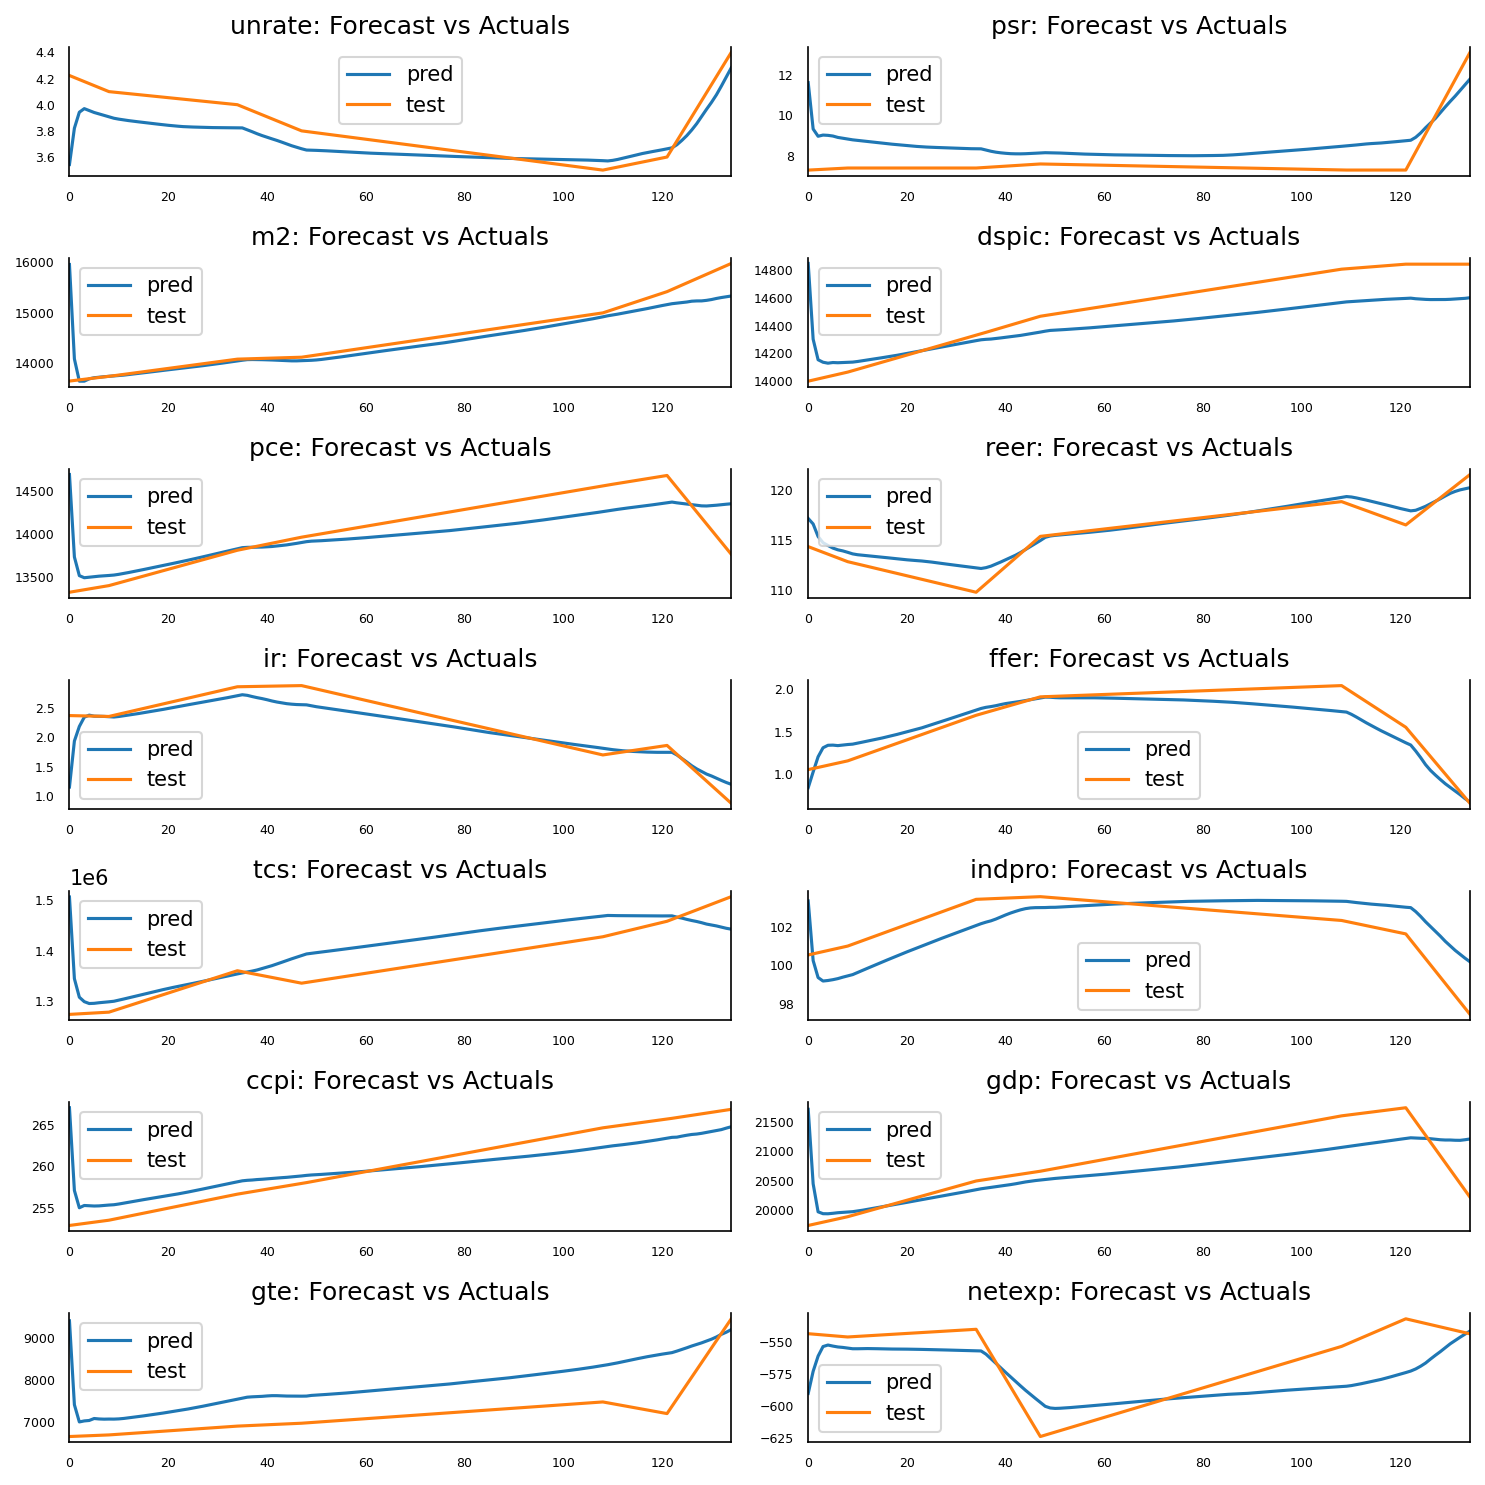

In [51]:
from tensorflow.keras.layers import BatchNormalization


def build_model_RNN(npas, hout, p):
    icol = 14
    grid_model = Sequential()
    grid_model.add(SimpleRNN(hout, input_shape=(npas,icol), activation='relu'))#, return_sequences=True))
    grid_model.add(Dense(icol + int((hout - icol) * 0.5)))
    grid_model.add(Dropout(p))
    grid_model.add(Dense(icol))

    grid_model.compile(loss = 'mse', optimizer = Adam(learning_rate=1e-3))
    return grid_model

#grid_model = KerasRegressor(model=build_model(npas, hout, p),verbose=1, fit__validation_data=(testX,testY))
grid_model = build_model_RNN(npas, hout, p)
'''grid_search  = GridSearchCV(estimator = grid_model,
                                param_grid = {'epochs': [15]},
                                cv = 2,
                                verbose=True)'''
grid_fit = grid_model.fit(trainX,trainY,epochs=10,batch_size=64,verbose=1)
prediction=grid_model.predict(testX)
testY_reverse, prediction_reverse = scaler.inverse_transform(testY), scaler.inverse_transform(prediction)
fig, axes = plt.subplots(nrows=7, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pd.Series(data=prediction_reverse[:, i], name="pred").plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    pd.Series(data=testY_reverse[:, i], name="test").plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [52]:
validate(testY_reverse, prediction_reverse)

MSE: 134181468.72110009
RMSE: 11583.672505777264
MAE: 2609.4144126527367
MAPE: 3.629577995797828
R2: 0.43950164741211595


Рекордно низкий MAPE - значит, очень небольшое расстояние между графиками. Да и графики предиктов по своей "форме", в отличие от классических моделей, очень похожи на реальные значения (разве что, кроме, indpro, у которого в предикте медленный рост, тогда как на самом деле - медленное убывание, а также gte, у которого заметно предикт заметно больше реальных значений). Тем не менее, R2 низкий.

Epoch 1/10
18/18 [==============================] - 169s 9s/step - loss: 0.0756
Epoch 2/10
18/18 [==============================] - 163s 9s/step - loss: 0.0088
Epoch 3/10
18/18 [==============================] - 166s 9s/step - loss: 0.0030
Epoch 4/10
18/18 [==============================] - 163s 9s/step - loss: 0.0016
Epoch 5/10
18/18 [==============================] - 164s 9s/step - loss: 0.0012
Epoch 6/10
18/18 [==============================] - 166s 9s/step - loss: 9.1490e-04
Epoch 7/10
18/18 [==============================] - 163s 9s/step - loss: 7.4695e-04
Epoch 8/10
18/18 [==============================] - 162s 9s/step - loss: 6.3172e-04
Epoch 9/10
18/18 [==============================] - 163s 9s/step - loss: 5.5926e-04
Epoch 10/10
5/5 [==============================] - 7s 1s/step


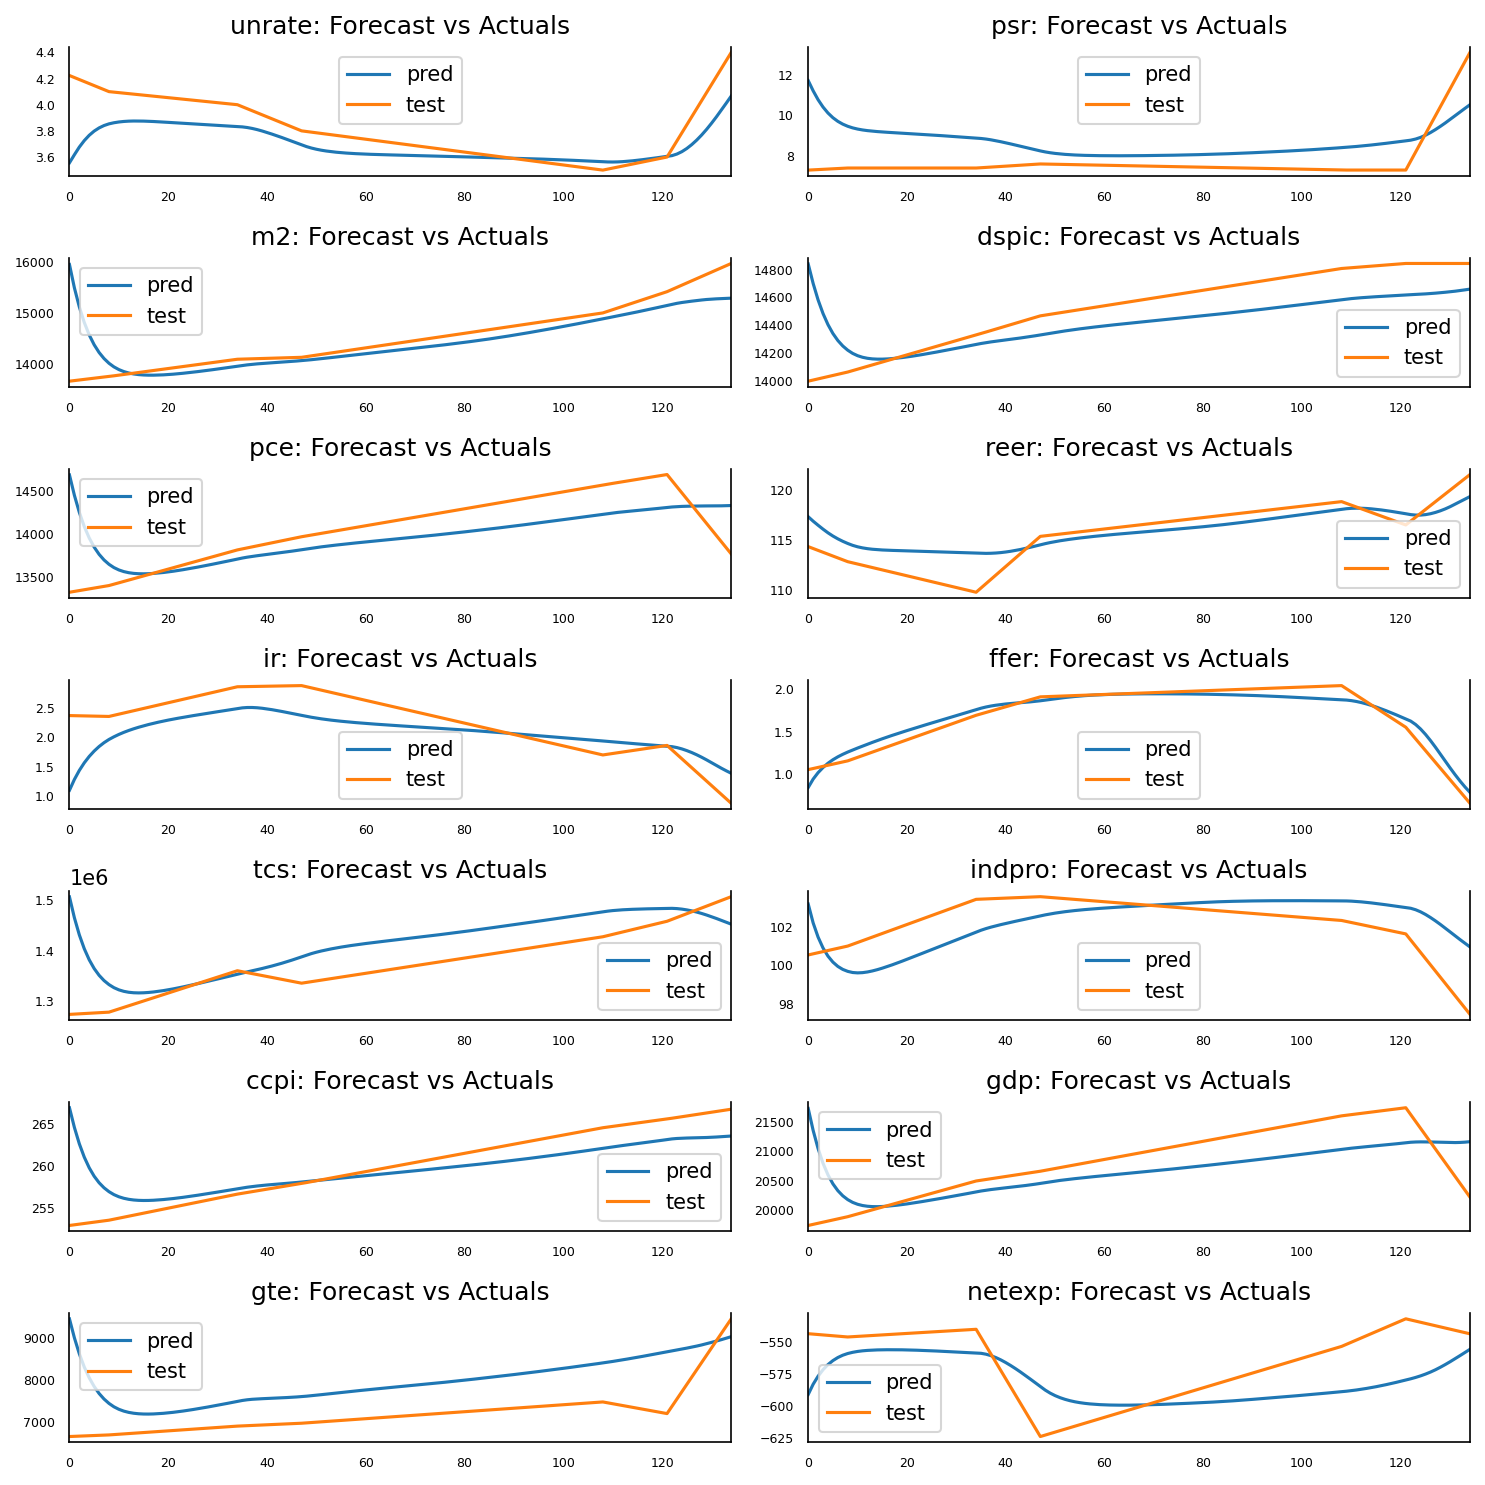

In [44]:
from tensorflow.keras.layers import BatchNormalization


def build_model_LSTM(npas, hout, p):
    icol = 14
    grid_model = Sequential()
    grid_model.add(LSTM(hout, input_shape=(npas,icol), activation='relu'))
    grid_model.add(Dropout(p))
    grid_model.add(Dense(icol + int((hout - icol) * 0.5)))
    grid_model.add(Dense(icol))

    grid_model.compile(loss = 'mse', optimizer = Adam(learning_rate=2e-4))
    return grid_model


#grid_model = KerasRegressor(model=build_model(npas, hout, p),verbose=1, fit__validation_data=(testX,testY))
grid_model = build_model_LSTM(npas, hout, p)
'''grid_search  = GridSearchCV(estimator = grid_model,
                                param_grid = {'epochs': [15]},
                                cv = 2,
                                verbose=True)'''
grid_fit = grid_model.fit(trainX,trainY,epochs=10,batch_size=64,verbose=1)
prediction=grid_model.predict(testX)
testY_reverse, prediction_reverse = scaler.inverse_transform(testY), scaler.inverse_transform(prediction)
fig, axes = plt.subplots(nrows=7, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pd.Series(data=prediction_reverse[:, i], name="pred").plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    pd.Series(data=testY_reverse[:, i], name="test").plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [45]:
validate(testY_reverse, prediction_reverse)

MSE: 204085864.82077774
RMSE: 14285.862410816428
MAE: 3174.0685168673276
MAPE: 4.572842938724193
R2: 0.1644346970990342


Ситуация как с предыдущей моделью: MAPE маленький, "формы" графиков друг на друга похожи, но R2 низкий.

Epoch 1/10
18/18 [==============================] - 102s 6s/step - loss: 0.0734
Epoch 2/10
18/18 [==============================] - 99s 5s/step - loss: 0.0060
Epoch 3/10
18/18 [==============================] - 102s 6s/step - loss: 0.0018
Epoch 4/10
18/18 [==============================] - 107s 6s/step - loss: 0.0011
Epoch 5/10
18/18 [==============================] - 103s 6s/step - loss: 7.9150e-04
Epoch 6/10
18/18 [==============================] - 105s 6s/step - loss: 6.1226e-04
Epoch 7/10
18/18 [==============================] - 104s 6s/step - loss: 5.1621e-04
Epoch 8/10
18/18 [==============================] - 105s 6s/step - loss: 4.6212e-04
Epoch 9/10
18/18 [==============================] - 109s 6s/step - loss: 3.9968e-04
Epoch 10/10
5/5 [==============================] - 5s 843ms/step


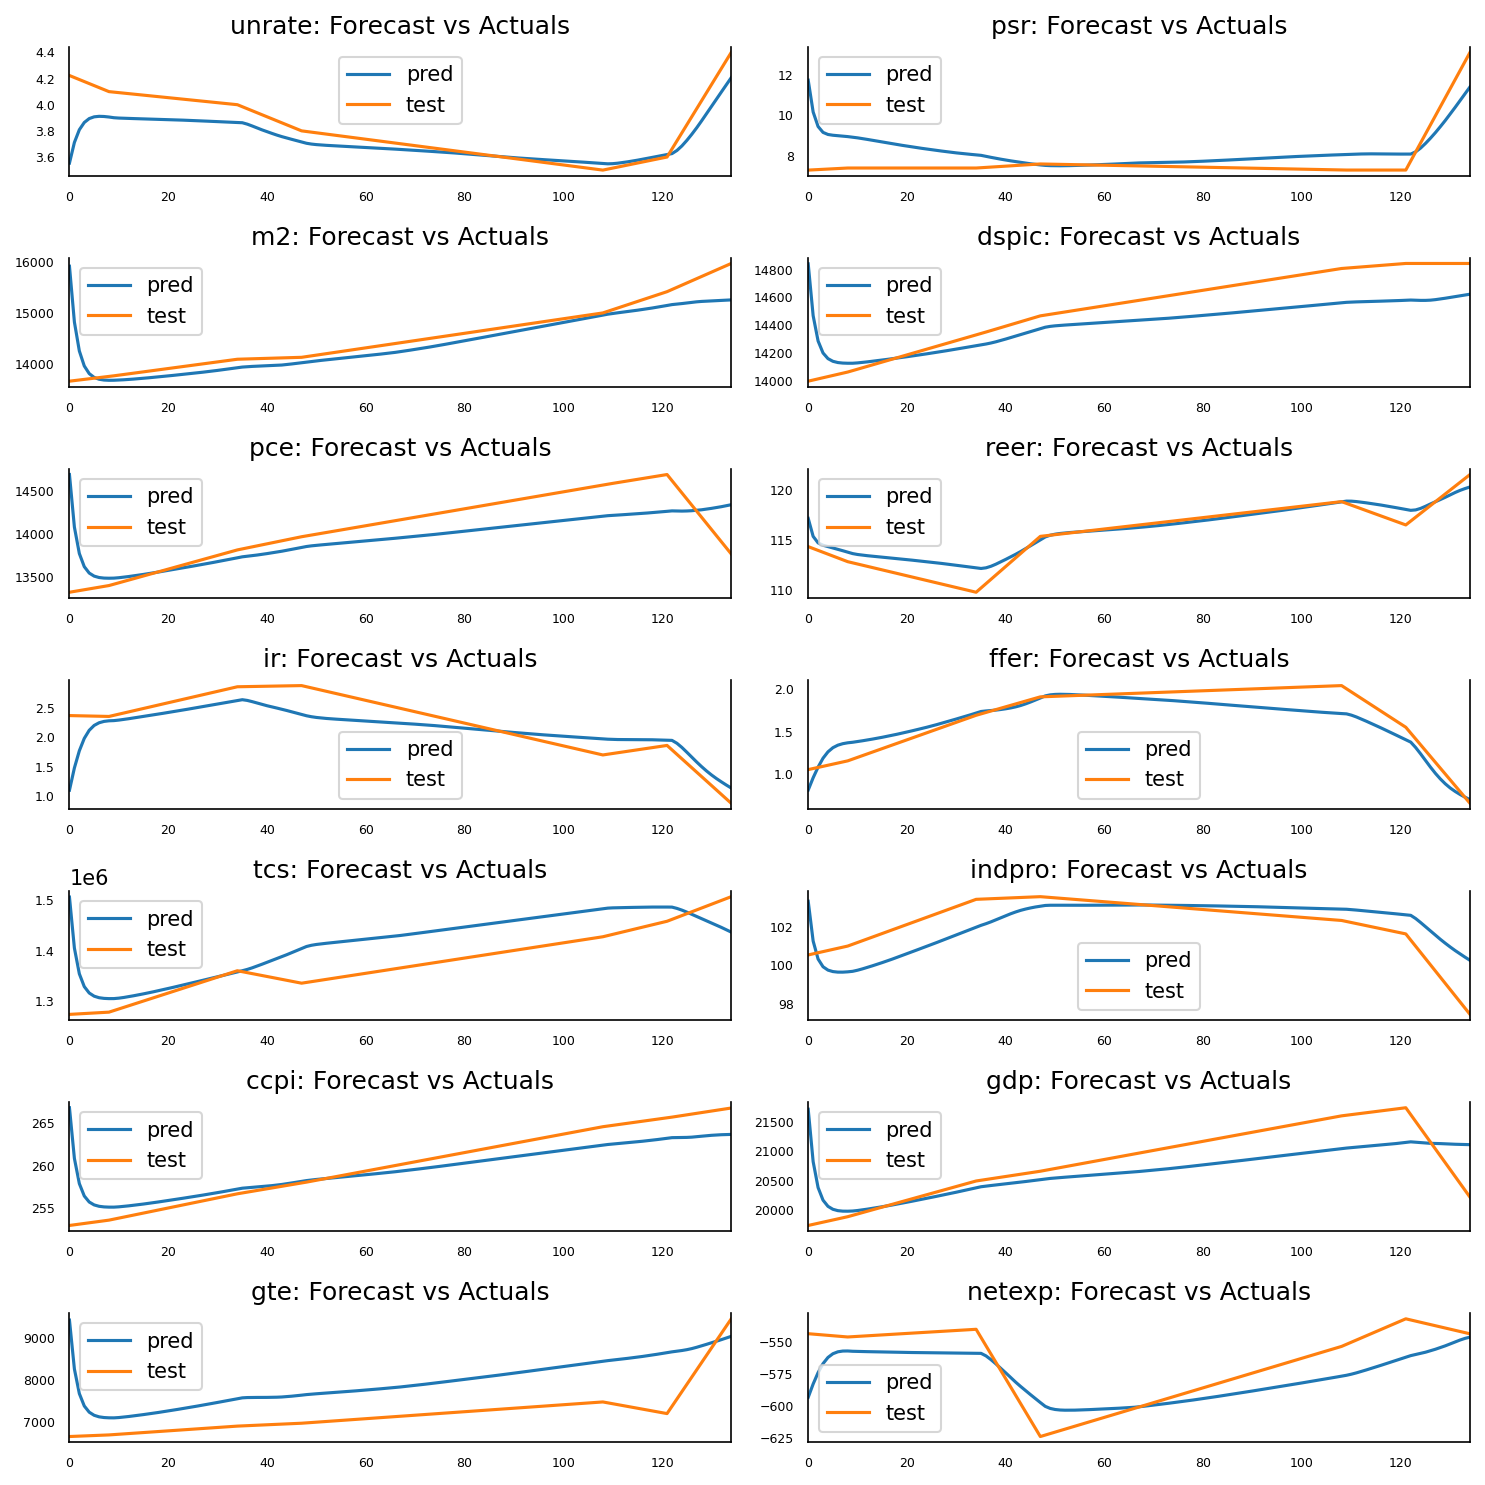

In [49]:
from tensorflow.keras.layers import BatchNormalization


def build_model_GRU(npas, hout, p):
    icol = 14
    grid_model = Sequential()
    grid_model.add(GRU(hout, input_shape=(npas,icol), activation='relu'))
    grid_model.add(Dropout(p))
    grid_model.add(Dense(icol + int((hout - icol) * 0.5)))
    grid_model.add(Dense(icol))

    grid_model.compile(loss = 'mse', optimizer = Adam(learning_rate=1e-3))
    return grid_model

#grid_model = KerasRegressor(model=build_model(npas, hout, p),verbose=1, fit__validation_data=(testX,testY))
grid_model = build_model_GRU(npas, hout, p)
'''grid_search  = GridSearchCV(estimator = grid_model,
                                param_grid = {'epochs': [15]},
                                cv = 2,
                                verbose=True)'''
grid_fit = grid_model.fit(trainX,trainY,epochs=10,batch_size=64,verbose=1)
prediction=grid_model.predict(testX)
testY_reverse, prediction_reverse = scaler.inverse_transform(testY), scaler.inverse_transform(prediction)
fig, axes = plt.subplots(nrows=7, ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    pd.Series(data=prediction_reverse[:, i], name="pred").plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    pd.Series(data=testY_reverse[:, i], name="test").plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [50]:
validate(testY_reverse, prediction_reverse)

MSE: 205897229.65097564
RMSE: 14349.11947301909
MAE: 3328.54768581498
MAPE: 3.775220545133272
R2: 0.3986039813171457


Несколько лучше, чем LSTM; в остальном - всё то же самое.

Заключение: хоть R2 на нейронных сетях и оказались невысоки, имеющиеся результаты уже довольно неплохи, демонстрируя гораздо меньший MAPE, чем на классических моделях. Модели пришлось остановить на 10 эпохах, чтобы обучение не шло несколько часов, однако во всех трёх случаях обучение останавливалось до того, как лосс прекращал уменьшаться, так что можно предположить, что при большем количестве эпох можно было бы увидеть отличный результат на всех метриках. Кроме того, для нейронных сетей не важна стационарность ряда, так что в копилке плюсов нейронных сетей пополнение. Так что между нейронными сетями и классическими моделями я выбрал бы первое.